In [1]:
!pip install numpy torch sympy mod blobfile pandas seaborn matplotlib tqdm einops wandb

import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from contextlib import suppress
from dataclasses import dataclass, asdict
from datetime import datetime
from typing import Callable, Literal, Optional, Union, Tuple, List
from copy import deepcopy

import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import optim
import wandb
from tqdm.notebook import tqdm
import ipywidgets as widgets
import wandb

import matplotlib as mpl
from matplotlib.colors import LogNorm
import seaborn as sns
import matplotlib.pyplot as plt

from patterns.dataset import ModularArithmetic, Operator
from patterns.transformer import Transformer
from patterns.utils import generate_run_name
from patterns.learner import Config, GrokkingLearner, GrokkingConfig

from unifying.sweep import get_history, handle_outliers

DEFAULT_MODULUS = 113
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sns.set_theme(style="darkgrid")

zsh:1: /Users/Jesse/Projects/pattern-learning/.venv/bin/pip: bad interpreter: /Users/Jesse/Projects/unifying-grok-dd/.venv/bin/python: no such file or directory


In [2]:
rw_grokking = get_history("2peyz0vr", "oxsp97s3", unique_cols="weight_decay")
rw_grokking_cleaned = handle_outliers(
    rw_grokking,
    loss_cols=["train/loss"], 
    action="remove",
    unique_cols=["weight_decay"],
    threshold=0.0001,
    late_epochs_ratio=0.6,
)

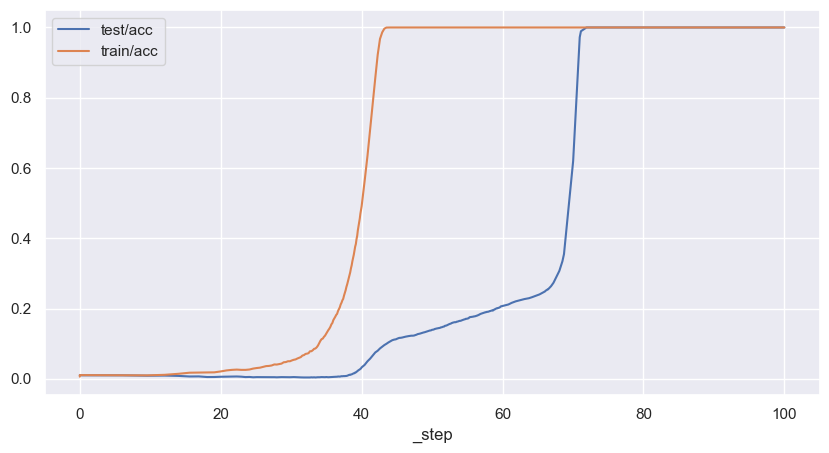

In [3]:
wds = rw_grokking_cleaned.weight_decay.unique()
run = rw_grokking_cleaned[rw_grokking_cleaned.weight_decay == wds[-1]]

def rescale_run(run):
    # Changes the steps to fit in the range [0, 100] (following a log scale)
    run = run.copy()
    max_ = np.log(run["_step"].max())
    run["_step"] = np.log(run["_step"]) / max_ * 100

    return run

rescaled_run = rescale_run(run)
rescaled_run.plot(x="_step", y=["test/acc", "train/acc"], figsize=(10, 5))
plt.show()

/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_27965/2684812831.py:104: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3281.)
  ts = torch.linspace(0, 100, 100).T
/Users/Jesse/Projects/pattern-learning/.venv/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


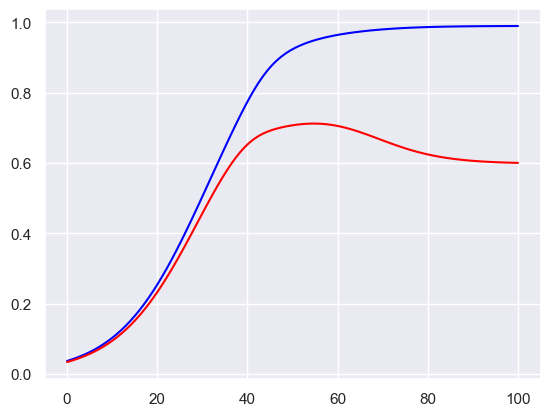

In [4]:
class Pattern(nn.Module):
    def __init__(self):
        # 4 scalar parameters: strength, speed, onset, generalization
        super().__init__()
        self.strength = nn.Parameter(torch.rand(1)[0])
        self.speed = nn.Parameter(torch.rand(1)[0])
        self.onset = nn.Parameter(torch.rand(1)[0] * 100)
        self.generalization = nn.Parameter(torch.rand(1)[0])

    def forward(self, t): 
        return self.strength * F.sigmoid(self.speed * (t - self.onset))

    def __repr__(self):
        return f"Pattern(strength={self.strength.data.float()}, speed={self.speed.data.float()}, onset={self.onset.data.float()}, generalization={self.generalization.data.float()})"

class GrokkingModel(nn.Module):
    def __init__(self, num_patterns: int = 3):
        super().__init__()
        self.num_patterns = num_patterns 
        self.patterns = nn.ModuleList([Pattern() for _ in range(num_patterns)])
        
        self.binary_mask = torch.tensor(
            [[int(i) for i in bin(j)[2:].zfill(num_patterns)] for j in range(2 ** num_patterns)]
        ).float()

        self.counts = self.binary_mask.sum(dim=1)

        # Register buffer for generalizations
        # self._generalizations = torch.zeros(2 ** num_patterns)
        self.register_buffer("_generalizations", torch.zeros(2 ** num_patterns))

    # def predictivenesses(self, t):
    #     return torch.stack([p(t) for p in self.patterns])
        
    # def forward(self, t):
    #     return 1 - torch.prod(1 - self.predictivenesses(t), dim=0)
    
    # def usages(self, t):
    #     preds = self.predictivenesses(t)
    #     usages = torch.prod(preds.T * self.binary_mask + (1 - preds.T) * (1 - self.binary_mask), dim=1)
    #     return usages

    # def gs(self):
    #     return torch.stack([p.generalization for p in self.patterns])

    # def generalizations(self):
    #     generalizations = torch.sum(self.gs().T * self.binary_mask, dim=1) / self.counts
    #     generalizations[0] = 0
    #     return generalizations

    # def test(self, t):
    #     return torch.sum(self.generalizations() * self.usages(t), dim=0)    
    
    def predictivenesses(self, t):
        return torch.stack([p(t) for p in self.patterns])
        
    def forward(self, t):
        prod = 1
    
        for p in self.patterns:
            prod *= 1 - p(t)
        
        return 1 - prod
        
    def usages(self, t):
        preds = [p(t) for p in self.patterns]
        usages = torch.ones(2 ** self.num_patterns)

        for i in range(2 ** self.num_patterns):
            for j in range(self.num_patterns):
                if i & (1 << j):
                    usages[i] *= preds[j]
                else:
                    usages[i] *= (1 - preds[j])

        return usages

    def gs(self):
        return torch.stack([p.generalization for p in self.patterns])

    def generalizations(self):
        self._generalizations *= 0

        for i in range(2 ** self.num_patterns):
            count = 0
            for j in range(self.num_patterns):
                if i & (1 << j):
                    # print(i, j, self.patterns[j].generalization, generalizations[i])
                    self._generalizations[i] += self.patterns[j].generalization
                    count += 1

            if count > 0:
                self._generalizations[i] /= count

        return self._generalizations

    def test(self, t):
        return torch.sum(self.generalizations() * self.usages(t), dim=0)  

torch.manual_seed(23)
gm = GrokkingModel()

def plot_patterns(gm):
    ts = torch.linspace(0, 100, 100).T
    train_preds = [gm(t).detach().numpy() for t in ts]
    test_preds = [gm.test(t).detach().numpy() for t in ts]

    plt.plot(ts, train_preds, label="train", color="blue")
    plt.plot(ts, test_preds, label="test", color="red")

plot_patterns(gm)


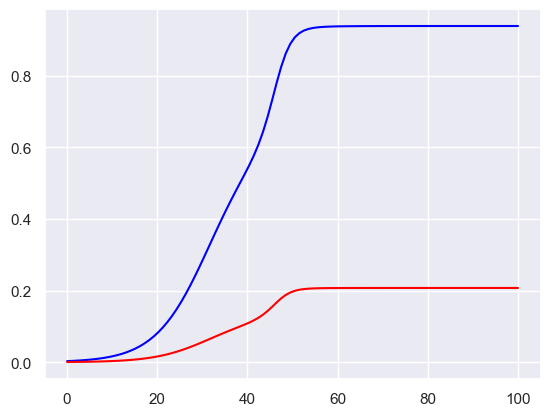

  0%|          | 0/1000 [00:00<?, ?it/s]

tensor([1.4872], grad_fn=<AddBackward0>)
None
None
None
None
None
None
None
None
None
None
None
None


/Users/Jesse/Projects/pattern-learning/.venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([772])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [5]:
def fit_patterns(run):
    gm = GrokkingModel()
    ts = torch.tensor(run._step.values).float()
    train_ys = torch.tensor(run["train/acc"].values).float()
    test_ys = torch.tensor(run["test/acc"].values).float()

    optimizer = optim.Adam(gm.parameters(), lr=0.00001)
    criterion = nn.MSELoss()
    # Cross-entropy 
    eps = 1e-6
    # criterion = lambda preds, ys: -torch.sum(ys * torch.log(preds + eps) + (1 - ys) * torch.log(1 - preds + eps))
    
    plot_patterns(gm)
    plt.show()

    for epoch in tqdm(range(1000)):
        for t in ts:
            optimizer.zero_grad()
            loss = torch.zeros(1)
            train_preds = gm(t)
            test_preds = gm.test(t)
            loss += criterion(train_preds, train_ys) + criterion(test_preds, test_ys) 
            print(loss)
            optimizer.step()

            # gradients
            for p in gm.parameters():
                print(p.grad)
            
            return gm

        if epoch < 10:
            print(f"Epoch {epoch} - loss: {loss.item()}")
            plot_patterns(gm)
            plt.show()

    return gm

gm = fit_patterns(rescaled_run)
